In [114]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [115]:
a = .1
b = .1
c = 4

C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)

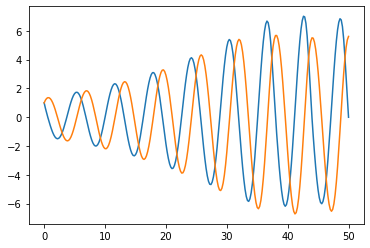

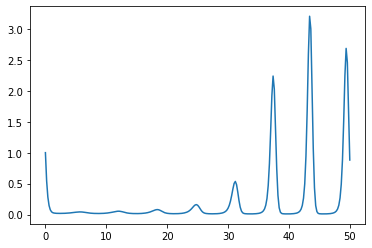

In [116]:
def ivp_rossler(t,z):
    x,y,z=z
    return -y-z,x+a*y,b+z*(x-c)

x0,y0,z0 = 1,1,1
tn = 50
dt = .2
ros_data = solve_ivp(ivp_rossler, (0,tn), (x0,y0,z0), method='RK45', t_eval=np.arange(0,tn+dt,dt))
plt.plot(ros_data.t,ros_data.y[0])
plt.plot(ros_data.t,ros_data.y[1])
plt.show()
plt.plot(ros_data.t,ros_data.y[2])
plt.show()

In [117]:
def rossler(x, y):
    """ODE system.
    dx = -y-z
    dy = x+a*y
    dz = b + z*(x-c)
    """
    
    x1 = y[:,0:1]
    y1 = y[:,1:2]
    z1 = y[:,2:]
    dx = dde.grad.jacobian(y, x, i=0)
    dy = dde.grad.jacobian(y, x, i=1)
    dz = dde.grad.jacobian(y, x, i=2)
    return [dx+y1+z1, dy-x1-C1*y1, dz-C2-z1*(x1-C3)]


def boundary(_, on_initial):
    return on_initial

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
        ),
        axis=1,
    )

In [118]:
y1 = np.array([ros_data.y[0]]).T
y2 = np.array([ros_data.y[0]]).T
y3 = np.array([ros_data.y[0]]).T
t = np.array([ros_data.t]).T

print(y1.shape,y2.shape,y3.shape,t.shape)

(251, 1) (251, 1) (251, 1) (251, 1)


In [119]:
geom = dde.geometry.TimeDomain(0, 50)
ic1 = dde.IC(geom, lambda X: 1, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 1, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 1, boundary, component=2)


obs_1 = dde.PointSetBC(t, y1, component=0)
obs_2 = dde.PointSetBC(t, y2, component=1)
obs_3 = dde.PointSetBC(t, y3, component=2)
data = dde.data.PDE(geom, rossler, [ic1, ic2,ic3, obs_1, obs_2, obs_3], num_domain = 500, num_boundary = 2, anchors = t)

C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn("The balance properties of Sobol' points require "


In [120]:
layer_size = [1] + [40] * 3 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
net.apply_feature_transform(input_transform)

Compiling model...
'compile' took 0.871104 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.00e-01, 1.48e+00, 1.56e-01, 1.00e+00, 1.00e+00, 1.00e+00, 1.06e+01, 1.19e+01, 1.11e+01]    [2.00e-01, 1.48e+00, 1.56e-01, 1.00e+00, 1.00e+00, 1.00e+00, 1.06e+01, 1.19e+01, 1.11e+01]    []  
1000      [3.62e+00, 1.05e+00, 3.70e-01, 9.19e-05, 1.12e-08, 5.79e-06, 4.74e+00, 5.88e+00, 8.52e+00]    [3.62e+00, 1.05e+00, 3.70e-01, 9.19e-05, 1.12e-08, 5.79e-06, 4.74e+00, 5.88e+00, 8.52e+00]    []  
2000      [3.76e+00, 7.79e-01, 4.47e-01, 9.42e-05, 5.21e-06, 1.36e-05, 4.28e+00, 6.21e+00, 8.46e+00]    [3.76e+00, 7.79e-01, 4.47e-01, 9.42e-05, 5.21e-06, 1.36e-05, 4.28e+00, 6.21e+00, 8.46e+00]    []  
3000      [3.75e+00, 7.38e-01, 4.72e-01, 9.76e-05, 8.64e-06, 1.45e-05, 4.20e+00, 6.26e+00,

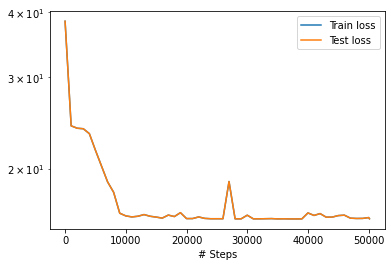

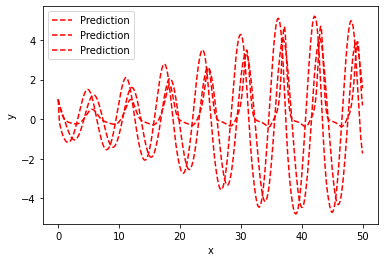

In [126]:
model = dde.Model(data, net)
model.compile("adam", lr=0.002, external_trainable_variables=[C1, C2, C3])
variable = dde.callbacks.VariableValue(
  [C1, C2, C3], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(epochs=50000,  callbacks=[variable])

model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

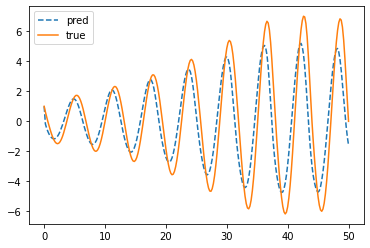

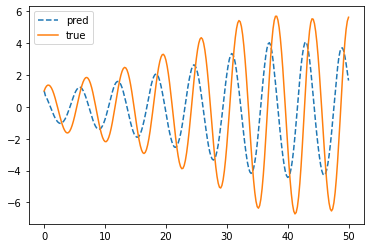

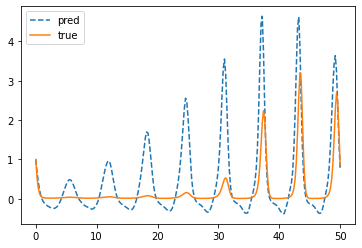

In [127]:
t = np.arange(0,50.2,.2).reshape(251, 1)
model_pred = model.predict(t)

plt.plot(t, model_pred[:,0:1], linestyle = 'dashed', label='pred')
plt.plot(ros_data.t, ros_data.y[0], label='true')
plt.legend()
plt.show()

plt.plot(t, model_pred[:,1:2], linestyle = 'dashed', label='pred')
plt.plot(ros_data.t, ros_data.y[1], label='true')
plt.legend()
plt.show()

plt.plot(t, model_pred[:,2:], linestyle = 'dashed', label='pred')
plt.plot(ros_data.t, ros_data.y[2], label='true')
plt.legend()
plt.show()

In [128]:
print('L2 relative error for x', dde.metrics.l2_relative_error(model_pred[:,0],ros_data.y[0]))
print('L2 relative error for y', dde.metrics.l2_relative_error(model_pred[:,1],ros_data.y[1]))
print('L2 relative error for z', dde.metrics.l2_relative_error(model_pred[:,2],ros_data.y[2]))

L2 relative error for x 0.6892767973950921
L2 relative error for y 1.451732222204778
L2 relative error for z 0.6923464182853163


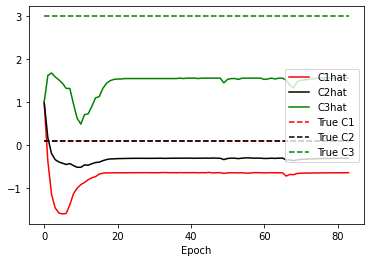

In [129]:
import re

lines = open("variables.dat", "r").readlines()
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*a,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*b,'k--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*c,'g--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.show()

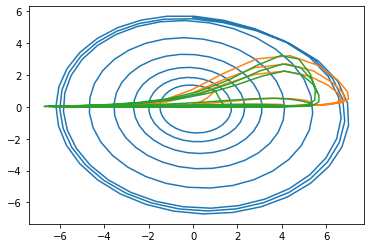

In [124]:
plt.plot(ros_data.y[0],ros_data.y[1])
plt.plot(ros_data.y[0],ros_data.y[2])
plt.plot(ros_data.y[1],ros_data.y[2])